# Skin Cancer detection and classification using HAM10000 dataset
Submitted by **Andrea DAVILA**


link to the HAM10000's kaggle page : https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000/data?select=HAM10000_images_part_2

## I. Data Extraction

### Importing the dataset from Kaggle's API

In [ ]:
!mkdir -p ~/.kaggle

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

#unzip the data
import zipfile

zip_ref = zipfile.ZipFile('/content/skin-cancer-mnist-ham10000.zip', 'r') #don't hesitate to right click on the zip file --> "copy path" and paste it here
zip_ref.extractall('/content') #destination of the unzipped file
zip_ref.close()

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.18G/5.20G [00:52<00:00, 154MB/s]
100% 5.20G/5.20G [00:52<00:00, 105MB/s]


### Read meatadata csv file

In [ ]:
import pandas as pd

df = pd.read_csv('/content/HAM10000_metadata.csv')

In [ ]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### Data Cleaning: checking for missing values

In [ ]:
df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,57
sex,0
localization,0


We could leave the dataset like this as we will not need the 'age' feature in our model. But let's just fill the blanks with the mean.

In [ ]:
df['age'].fillna((df['age'].mean()), inplace=True) #inplace = True means that we're applying the transformation to the current dataset, not creating a copy().

<ipython-input-5-92df45cdc176>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna((df['age'].mean()), inplace=True) #inplace = True means that we're applying the transformation to the current dataset, not creating a copy().


In [ ]:
df.isnull().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0


### dropping any image duplicates

In [ ]:
df = df.drop_duplicates(subset = ['image_id']) #look for image duplicates.

In [ ]:
df.shape

(10015, 7)

There was no duplicate !

### Check if all images are the same size, that part of the code was generated using chatGPT

In [ ]:
import os
from PIL import Image
from collections import Counter


def get_image_size(image_path):
    """Get the size of the image as a tuple (width, height)."""
    try:
        with Image.open(image_path) as img:
            return img.size
    except Exception as e:
        print(f"Error reading {image_path}: {e}")
        return None

def count_image_sizes(directory):
    """Count the number of images for each size in the specified directory."""
    size_counter = Counter()

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        if os.path.isfile(filepath):
            size = get_image_size(filepath)
            if size:
                size_counter[size] += 1

    return size_counter

def display_image_size_counts(directory):
    """Display the count of images for each size detected."""
    size_counts = count_image_sizes(directory)

    if size_counts:
        print("Image size counts:")
        for size, count in size_counts.items():
            print(f"Size {size}: {count} image(s)")
    else:
        print("No valid images found.")


display_image_size_counts("/content/HAM10000_images_part_1")
display_image_size_counts("/content/HAM10000_images_part_2")

Image size counts:
Size (600, 450): 5000 image(s)
Image size counts:
Size (600, 450): 5015 image(s)


All images have the same dimension (450x600)

## II. Data exploration and visualisation

### Plot random samples for a specific class

In [ ]:
import matplotlib.pyplot as plt

def plot_samples(df, dx, n, seed = 0, display = True):
  """
  Plots n samples of a given diagnosis dx.

    Args:
        df (pd.DataFrame): dataframe containing the metadata.
        dx (str): diagnosis to plot.
        n (int): number of samples to plot.
        seed (int): random seed.

    Returns:
        list: list of file paths of the plotted samples.

    Example:
        plot_samples(df, 'nv', 5)
  """
  file_path_list = []

  df_filtered = df[df["dx"] == dx] #only keep the class we want to plot
  df_filtered = df_filtered.sample(n, random_state = seed) #choses randomly samples from df_filtered
  df_filtered.reset_index(drop=True, inplace=True) #resets the index of df_filtered
  plt.figure(figsize = (15, 15))
  for i, row in df_filtered.iterrows():
    s = row['image_id'] #string that is the image_id
    threshold = 29306  #ISIC_0029306 is the ID of the first img from the part2 file of the dataset
    #Extract the numeric part and convert to integer
    number = int(s[5:])
    #Check if the number is greater than or equal to the threshold
    if number >= threshold :
      file_path = "/content/HAM10000_images_part_2/" + s + ".jpg"
    else :
      file_path = "/content/HAM10000_images_part_1/" + s + ".jpg"

    file_path_list.append(file_path)

    if display: #for computation efficiency
      plt.subplot(1, n, i + 1)
      plt.imshow(plt.imread(file_path))
      plt.title(f"{row['dx']} - {row['lesion_id']}")
      plt.axis("off")

  if display:
    plt.show()
  return file_path_list

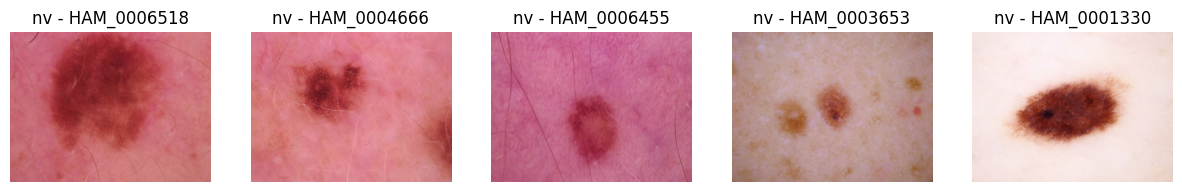

In [ ]:
plot_samples(df, 'nv', 5, 1);

### Plot bar charts to visualize the data distribution.

In [ ]:
import matplotlib.cm as cm

def plot_barh(df, feature, file_name = None, count_sort=True):
  """
  Plots a horizontal bar chart from a DataFrame, visualizing the counts of a specified feature.

    Args:
        df (DataFrame): The input DataFrame containing the data.
        feature (str): The name of the feature (column) for which counts are to be plotted.
        file_name (str, optional): The name of the file to save the plot as an image. If not provided, the plot will not be saved.
        count_sort (bool, optional): Determines whether to sort the bars by count in descending order. Default is `True`.

    Returns:
        None

    Example:
        plot_barh(df, 'dx')
  """
  #we have to create a subdataset with only the feature we're interested in and the count
  df_feature= df.groupby(feature).size().reset_index(name='count')
  if count_sort: #Sort by count in descending order, to make the plot fancier
    df_feature= df_feature.sort_values(by='count', ascending=False)

  #We have to normalize the data because color maps only consider values between 0 and 1
  norm = plt.Normalize(df_feature['count'].min(), df_feature['count'].max())

  colors = cm.viridis(norm(df_feature['count'])) #choice of the colormap, here we chose viridis

  #plot the horizontal bar chart with the colormap
  df_feature.plot.barh(x=feature, y='count', color=colors, legend=False)
  plt.xlabel('Count')
  #if we want to save the plot in high definition
  if file_name != None:
    plt.savefig(file_name + '.png', dpi=300)
  plt.show()

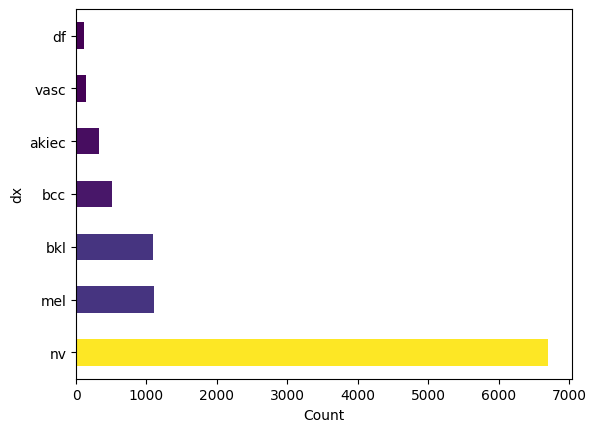

In [ ]:
plot_barh(df, 'dx')

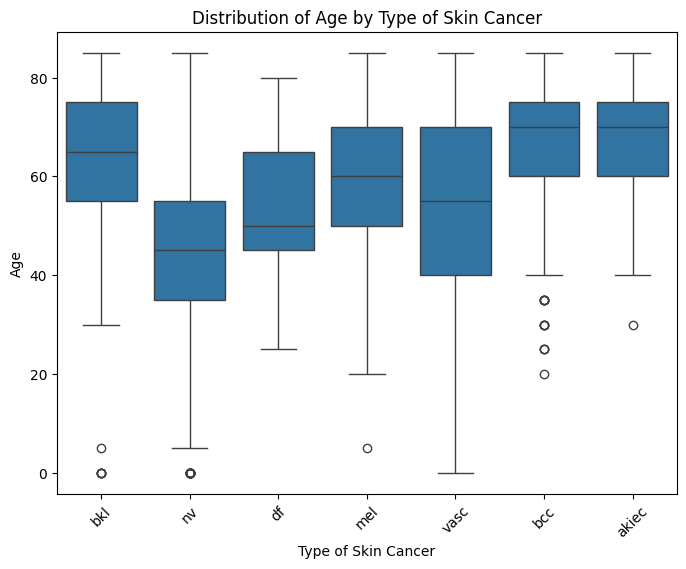

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='dx', y='age', data=df)
plt.title('Distribution of Age by Type of Skin Cancer')
plt.xlabel('Type of Skin Cancer')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

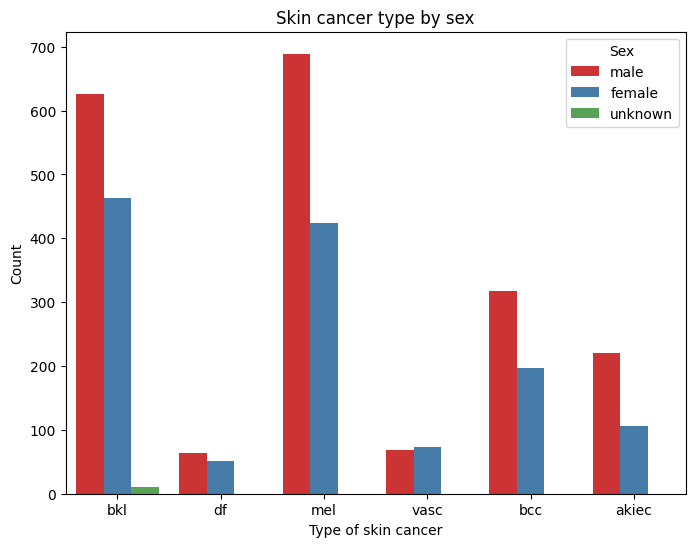

In [ ]:
plt.figure(figsize=(8, 6))
df_plot = df[df['dx'] != 'nv'] #nv class completely overshadows the other categories for this plot, so we don't include it
sns.countplot(x='dx', hue='sex', data=df_plot, palette='Set1')
plt.title('Skin cancer type by sex')
plt.xlabel('Type of skin cancer')
plt.ylabel('Count')
plt.legend(title='Sex')
plt.show()

**Please note** that the detailed data exploration is included in the written report. Here, we are only presenting the tools and code used for the analysis.

## III. Data Preprocessing

### Hair removal : we'll use the DullRazor algorithm ; it also removes the corners of dermoscopy images
function adapted from https://github.com/BlueDokk/Dullrazor-algorithm/blob/main/ISIC_0031023.jpg

In [ ]:
def dullrazor(image_path):
  """
  Applies the dull razor hair removal algorithm to an RGB image.

    Args:
        image_path (string): the path to the image file.

    Returns:
        numpy.ndarray: The image with the hair removed (450, 600, 3) shaped.

    Example:
        dullrazor(image_rgb) returns an rgb image with the hair removed.
  """

  image=cv2.imread(image_path,cv2.IMREAD_COLOR) #image is read in BGR
  img=image[30:410,30:560]
  grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
  #Black hat filter
  kernel = cv2.getStructuringElement(1,(9,9))
  blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
  #Gaussian filter
  bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
  #Binary thresholding (MASK)
  ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
  #Replace pixels of the mask
  dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)
  #retransform the image to RGB
  dullrazor_image = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

  return dullrazor_image

### Plot samples processed with dullrazor

In [ ]:
def sample_dullrazor(df, label, n, seed=0, display=True):
    """
    Applies dullrazor to n random samples and plots the result if display=True

      Args:
        df (pd.DataFrame): dataframe containing the metadata.
        label (str): diagnosis to plot.
        n (int): number of samples to plot.
        seed (int): random seed.
        display (bool): whether to display the images.

      Returns:
        list: list of transformed images.

      Example:
        sample_dullrazor(df, 'nv', 5)
    """

    file_path_list = plot_samples(df, label, n, seed, False) #we don't want the plot from the plot_samples function

    transformed_images = []
    if display:
        fig, axes = plt.subplots(n, 2, figsize=(10, n * 2))

    for i, path in enumerate(file_path_list):
        dullrazor_image = dullrazor(path)
        transformed_images.append(dullrazor_image)
        if display:
          #original image
          axes[i, 0].imshow(plt.imread(path))
          axes[i, 0].axis("off")
          axes[i, 0].set_title(f"Original {i+1}")

          #hair removed image
          axes[i, 1].imshow(dullrazor_image)
          axes[i, 1].axis("off")
          axes[i, 1].set_title(f"Transformed {i+1}")
    if display:
      plt.tight_layout()
      plt.show()

    return transformed_images

<Figure size 1500x1500 with 0 Axes>

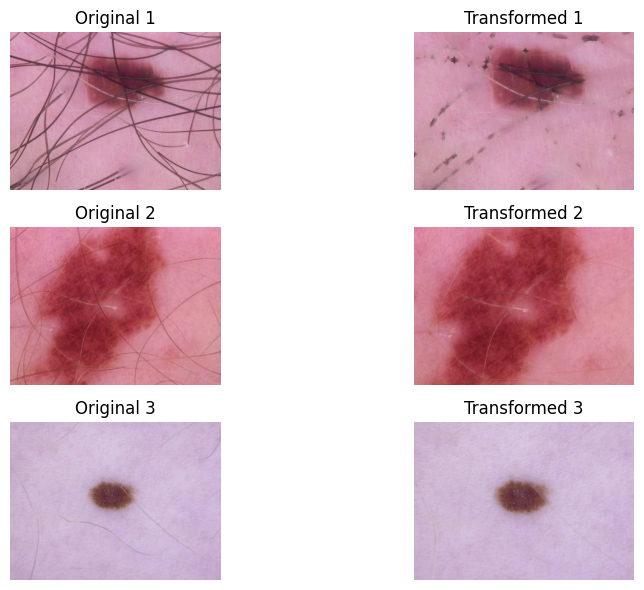

In [ ]:
hair_removed = sample_dullrazor(df, 'nv', 3, 0);

### Lesion segmentation using Otsu's thresholding method


In [ ]:
def otsu(hair_removed):
  """
  Applies Otsu's thresholding to a hair removed image.

    Args:
        hair_removed (numpy.ndarray): the RGB image with the hair removed

    Returns:
        tuple: a tuple containing the binary mask and the segmented image.
  """
  #only keep the RED channel (researchers always use this one for the segmentation of skin cancers)
  red_channel = hair_removed[:, :, 0]

  #we apply a gaussian blur for better results
  blurred = cv2.GaussianBlur(red_channel, (5, 5), 0)

  #apply Otsu's thresholding method
  _, otsu_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

  #create and use the mask obtained with Otsu's method and apply it to the original image
  black_pixel_mask = otsu_thresh == 0
  black_pixels_image = np.zeros_like(hair_removed)
  black_pixels_image[black_pixel_mask] = hair_removed[black_pixel_mask]

  return otsu_thresh, black_pixels_image

### Plot samples of the result of Otsu's thresholding

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sample_otsu_thresholding(image_list, display=True):
    """Apply Otsu's thresholding to a list of images and plots the result if display=True"""

    segmented_images = []
    if display:
        fig, axes = plt.subplots(len(image_list), 3, figsize=(15, len(image_list) * 2))

    for i, image in enumerate(image_list):

        otsu_thresh, black_pixels_image = otsu(image)
        segmented_images.append(otsu_thresh)

        if display:
            # hair_removed image
            axes[i, 0].imshow(image)
            axes[i, 0].axis('off')
            axes[i, 0].set_title(f"Original {i+1}")

            # Otsu's Thresholding result
            axes[i, 1].imshow(otsu_thresh, cmap='gray')
            axes[i, 1].axis('off')
            axes[i, 1].set_title(f"Otsu's Thresholding {i+1}")

            # Segmented image with black regions
            axes[i, 2].imshow(black_pixels_image)
            axes[i, 2].axis('off')
            axes[i, 2].set_title(f"Segmented {i+1}")

    if display:
        plt.tight_layout() #makes sure there are no overlaps within the plots
        plt.show()

    return segmented_images


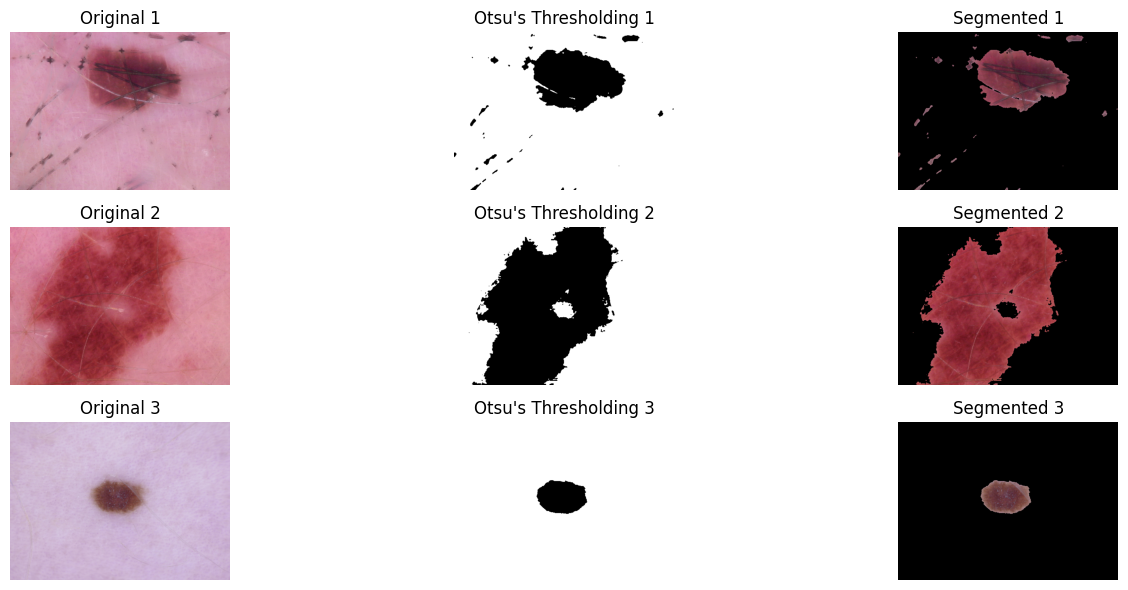

In [ ]:
sample_otsu_thresholding(hair_removed);

On regular moles, the segmentation seems to work well.
However, when the hair removal isn't perfect or the mole irregular, there are holes and bits to get rid of. This can be achieved through morphological operations that will be done in stage 2 (lack of time).

### Applying the transformations to all the dataset

We're not gonna use the transformed data from this part of the script for now, as there are improvements to be made on the segmentation.

In [ ]:
def segment(file_path):
  """applies hair removal and segmentation operations on the image at the file_path"""
  hair_removed = dullrazor(file_path)
  segmented_image = otsu(hair_removed)
  return segmented_image

In [ ]:
import os

filepath = {} #will be the dictionary in which keys are the name of the file and value is the path to the file
directory1 = "/content/HAM10000_images_part_1"
directory2 = "/content/HAM10000_images_part_2"
file_name_list_1 = os.listdir(directory1)
file_name_list_2 = os.listdir(directory2)

#get file list and path to each image.
for filename in file_name_list_1:
  filepath[filename] = os.path.join(directory1, filename)

for filename in file_name_list_2:
  filepath[filename] = os.path.join(directory2, filename)

X = []
y = []
#apply dullrazor to the data

from tqdm import tqdm #for the progress bar
import time

start_time = time.time()

for key in tqdm(filepath.keys()):
  X.append(segment(filepath[key])[1])
  y.append(df[df['image_id'] == key.split('.')[0]]['dx'].values[0]) #append the label of the image, by isolating the image_id (i.e. removing the .jpg part)

end_time = time.time()
execution_time = end_time - start_time  # Calculate the duration
print(f"Execution time: {execution_time} seconds")

100%|██████████| 10015/10015 [11:54<00:00, 14.01it/s]

Execution time: 714.7539865970612 seconds
